#### In this notebook, I am going to run Gridsearch on LogisticRegression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report,\
plot_roc_curve

In [2]:
nut_die=pd.read_csv('../data/nutrition_vs_dietetics.csv')

In [3]:
nut_die.head()

,nd_subreddit,nd_title_text,nd_length,nd_word_count,nd_sentiment
0,1,Please help me figure out what’s wrong with my...,84,12,0.2942
1,1,What Tests For Iron Deficiency? Looking at get...,335,54,0.6544
2,1,How to get protein as a picky eater? [removed],46,9,0.0000
3,1,Suffering with canker sores [removed],37,5,-0.4767
4,1,Good diets/work outs? I am trying to lose weig...,204,39,0.2960


### Baseline

In [4]:
nut_die['nd_subreddit'].value_counts(normalize=True)

0    0.502927
1    0.497073
Name: nd_subreddit, dtype: float64

### Set X and y variables

In [5]:
# Separate the numerical features and the text feature

get_text_data = FunctionTransformer(lambda x: x['nd_title_text'], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x[['nd_length', 'nd_word_count','nd_sentiment']], validate = False)

In [6]:
nut_die['nd_title_text']=nut_die['nd_title_text'].str.replace('[^\w\s]', '')

X=nut_die[['nd_title_text','nd_length', 'nd_word_count','nd_sentiment']]
y=nut_die['nd_subreddit']

#after testing multiple times, when I replace all the puntuations when I set X, it improves
#the train score with estimator using TfidfVectorizer, 
#but decrease the train score with estimator using CountVectorizer
#Overall, doesn't make much difference

<ipython-input-6-aaa6985785fc>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  nut_die['nd_title_text']=nut_die['nd_title_text'].str.replace('[^\w\s]', '')


In [7]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=66,
                                               test_size=0.33,stratify=y)

## LogisticRegression with CountVectorizer

In [8]:
# customize the stopwords

stopwords = nltk.corpus.stopwords.words('english')
newstopwords=['rd','ve','does','nutrition','removed','deleted','would','ive','dont',"'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo']
stopwords.extend(newstopwords)

`adding LemmaTokenizer into CountVectorizer`

In [9]:
#https://scikit-learn.org/stable/modules/feature_extraction.html
#https://stackoverflow.com/questions/50155188/lemmatization-on-countvectorizer-doesnt-remove-stopwords
#https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer

class LemmaTokenizer:
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in stopwords]

In [10]:
pipe_c = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer(tokenizer=LemmaTokenizer(),
                                        stop_words=stopwords))
            ]))
    ])),
    ('logreg', LogisticRegression(max_iter=10000,solver='liblinear'))
])

In [11]:
cross_val_score(pipe_c, X, y).mean()

0.8770655256802969

In [12]:
#pipe.get_params()
pipe_c.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'features', 'logreg', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__verbose', 'features__numeric_features', 'features__text_features', 'features__numeric_features__memory', 'features__numeric_features__steps', 'features__numeric_features__verbose', 'features__numeric_features__selector', 'features__numeric_features__ss', 'features__numeric_features__selector__accept_sparse', 'features__numeric_features__selector__check_inverse', 'features__numeric_features__selector__func', 'features__numeric_features__selector__inv_kw_args', 'features__numeric_features__selector__inverse_func', 'features__numeric_features__selector__kw_args', 'features__numeric_features__selector__validate', 'features__numeric_features__ss__copy', 'features__numeric_features__ss__with_mean', 'features__numeric_features__ss__with_std', 'features__text_features__memory', 'features__text_features__steps', 'features__text_features__ve

In [13]:
pipe_parames_c={'features__text_features__cvec__max_features':[3000,4000],
             'features__text_features__cvec__min_df':[2,3],
                'features__text_features__cvec__max_df':[.8,.85],
             'features__text_features__cvec__ngram_range':[(1,1),(1,2)],
             'logreg__C':np.linspace(0.0001,1,5),
             'logreg__penalty':['l1','l2']}

In [14]:
pipe_gridsearch_c=GridSearchCV(pipe_c,pipe_parames_c,cv=5)

In [15]:
pipe_gridsearch_c.fit(X_train,y_train);

In [16]:
pipe_gridsearch_c.best_score_

0.869686365899236

In [17]:
pipe_gridsearch_c.best_params_

{'features__text_features__cvec__max_df': 0.8,
 'features__text_features__cvec__max_features': 4000,
 'features__text_features__cvec__min_df': 2,
 'features__text_features__cvec__ngram_range': (1, 2),
 'logreg__C': 0.7500249999999999,
 'logreg__penalty': 'l2'}

In [18]:
train_score_c=pipe_gridsearch_c.score(X_train,y_train)
train_score_c

0.9677051671732523

In [19]:
test_score_c=pipe_gridsearch_c.score(X_test,y_test)
test_score_c

0.882035466461064

In [20]:
train_score_c-test_score_c #overfit

0.08566970071218827

In [21]:
y_pred_c=pipe_gridsearch_c.predict(X_test)
y_pred_c

array([1, 1, 1, ..., 0, 1, 1])

In [22]:
print(classification_report(y_test,y_pred_c))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       652
           1       0.84      0.94      0.89       645

    accuracy                           0.88      1297
   macro avg       0.89      0.88      0.88      1297
weighted avg       0.89      0.88      0.88      1297



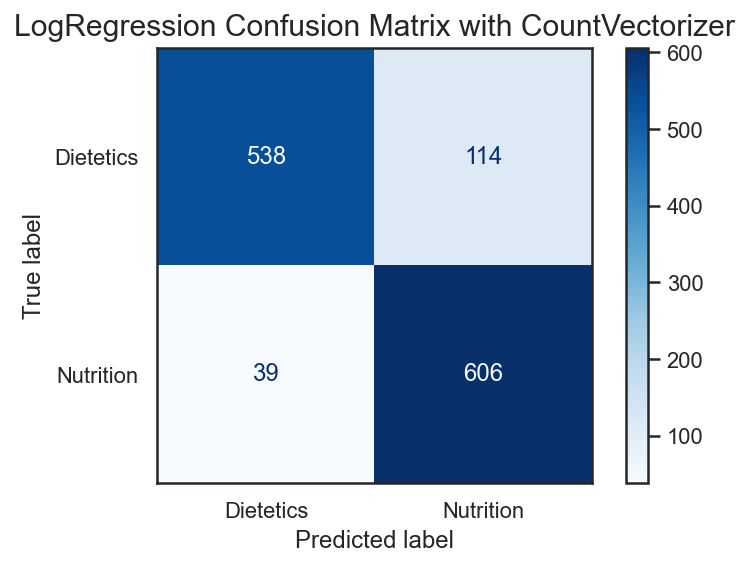

<Figure size 1440x720 with 0 Axes>

In [23]:
# confusion matrix for Log Regression 

sns.set(font_scale=1)
sns.set_style('white')

plot_confusion_matrix(pipe_gridsearch_c, X_test, y_test, cmap='Blues', 
                      display_labels=['Dietetics', 'Nutrition'])

plt.title('LogRegression Confusion Matrix with CountVectorizer',size=15)

plt.figure(figsize=(20,10));

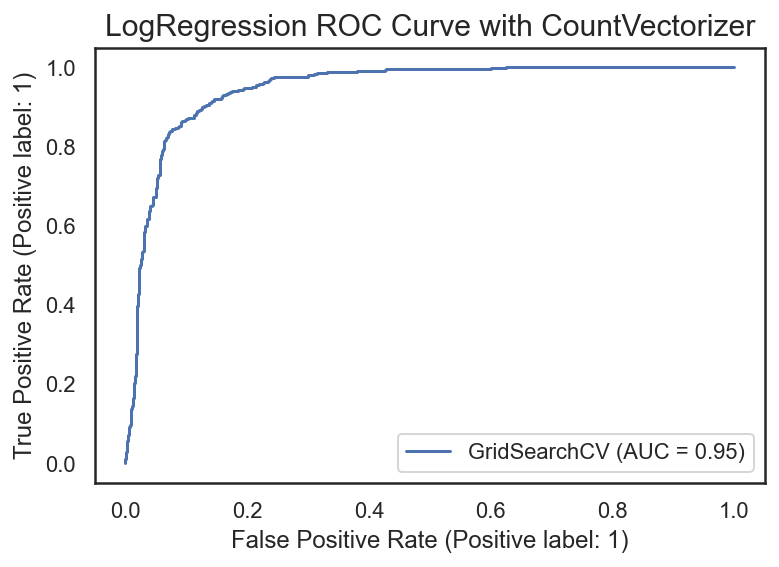

<Figure size 1440x720 with 0 Axes>

In [24]:
# ROC curve for Log Regression

sns.set(font_scale=1)
sns.set_style('white')

plot_roc_curve(pipe_gridsearch_c,X_test,y_test)

plt.title('LogRegression ROC Curve with CountVectorizer',size=15)
plt.figure(figsize=(20,10));

### Features and Coefficients

In [25]:
# create a df for the features and coefficients

features = pipe_gridsearch_c.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['cvec'].get_feature_names()
coefficients =pipe_gridsearch_c.best_estimator_.named_steps['logreg'].coef_[0]

In [26]:
fe_co_c_df=pd.DataFrame({'features': ['nd_length', 'nd_word_count','nd_sentiment']+ features, 
              'coef' : coefficients,
              'exp_coef': [np.exp(coef) for coef in coefficients]})

In [27]:
fe_co_c_df.head()

,features,coef,exp_coef
0,nd_length,-0.608007,0.544435
1,nd_word_count,-0.122842,0.884403
2,nd_sentiment,-0.082523,0.920790
3,0,0.000002,1.000002
4,1,-0.470833,0.624482


> most important words predicting nutrition subreddit

In [28]:
words_c_nut=fe_co_c_df.sort_values(by=['exp_coef'],ascending=False)[:15][::-1]
words_c_nut

,features,coef,exp_coef
579,calorie,0.759405,2.137005
2562,online,0.765230,2.149488
516,bread,0.765513,2.150098
3137,rice,0.783975,2.190160
1745,hungry,0.795213,2.214912
3880,water,0.832219,2.298414
927,daily,0.835758,2.306562
2788,powder,0.875166,2.399273
3960,workout,0.879455,2.409587
1090,drink,0.942741,2.567009


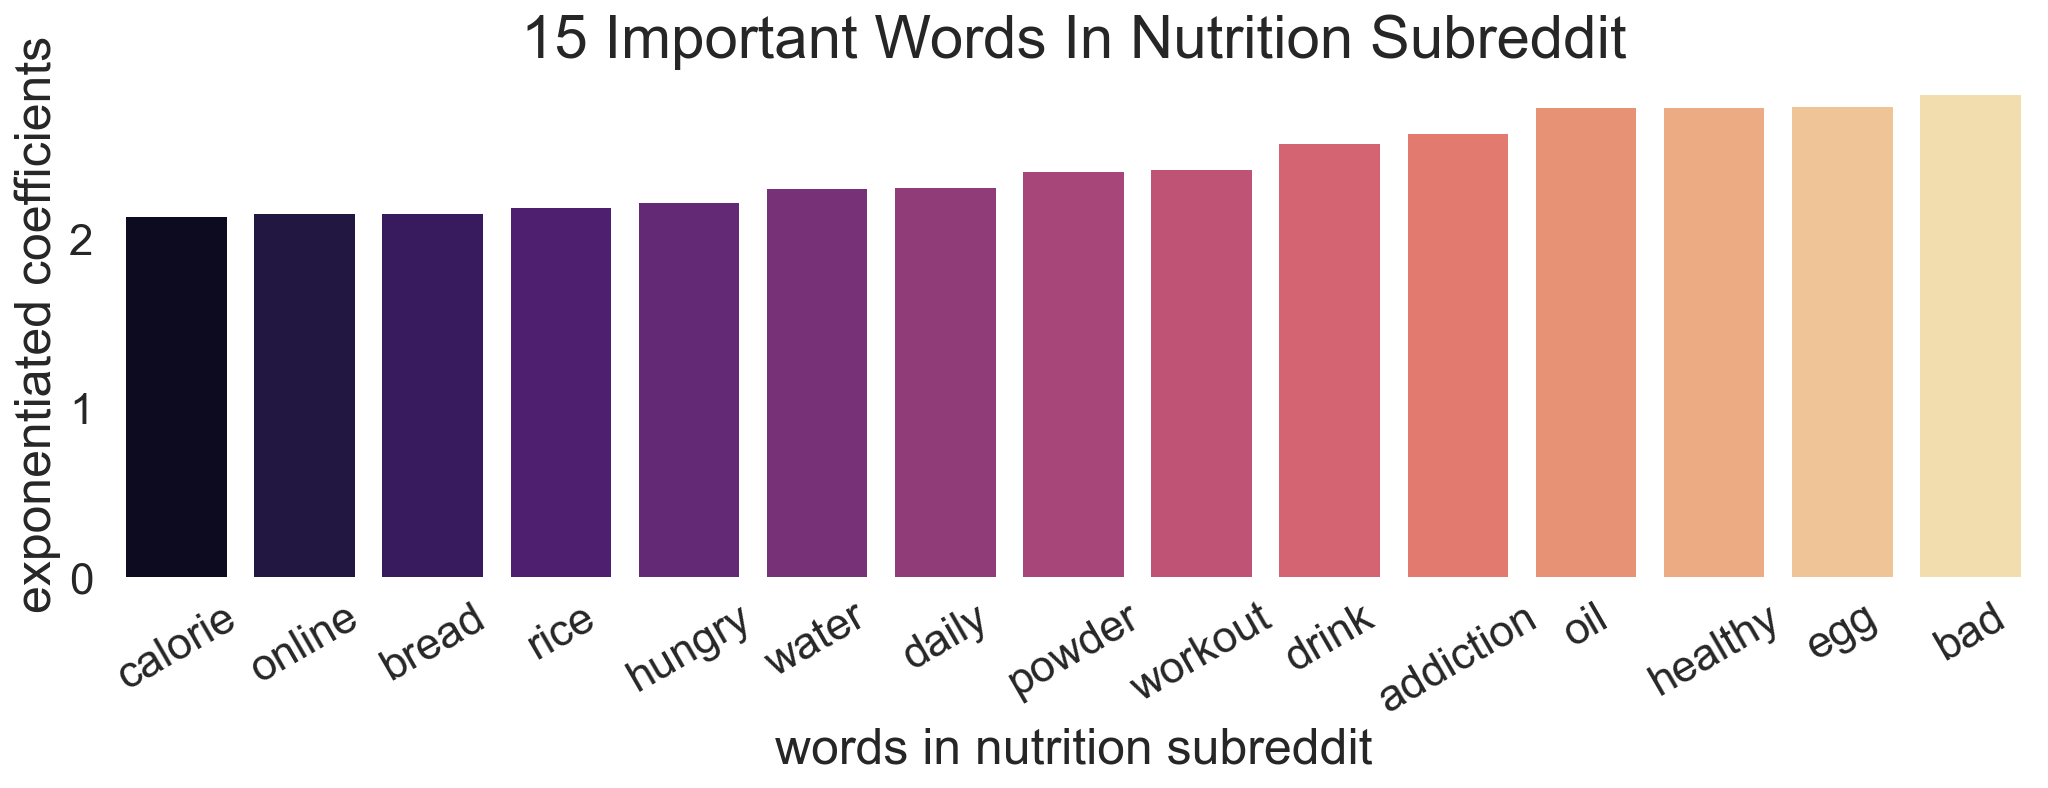

In [29]:
plt.figure(figsize=(15,6))

sns.set(font_scale=2)#change the font size for charts in entire notebook
sns.set_style('white')

sns.barplot(data=words_c_nut,y=words_c_nut['exp_coef'],x=words_c_nut['features'],
           palette='magma');

plt.xlabel("words in nutrition subreddit",size=25)
plt.ylabel("exponentiated coefficients",size=25)
plt.title('15 Important Words In Nutrition Subreddit',size=30);

plt.xticks(rotation=30)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout()
plt.savefig('../images/important_words_nutrition',transparent=True);

# plot the 15 most important words to predict Nutrition subreddit,
# including 'workout, hungry, online, calorie'

**bad is the most important words predicting nutrition subreddit**

> most important words predicting dietetics subreddit

In [30]:
# create a df for the important words predicting dietetics subreddit

words_c_die=fe_co_c_df.sort_values(by=['exp_coef'])[:15]
words_c_die

,features,coef,exp_coef
1017,dietetics,-2.086827,0.124080
1228,exam,-1.998791,0.135499
1025,dietitian,-1.950686,0.142177
2641,patient,-1.844078,0.158171
1960,job,-1.742153,0.175143
728,clinical,-1.588433,0.204245
2969,rds,-1.493368,0.224615
1924,internship,-1.454221,0.233582
2212,ltc,-1.391774,0.248634
1023,dietician,-1.314096,0.268717


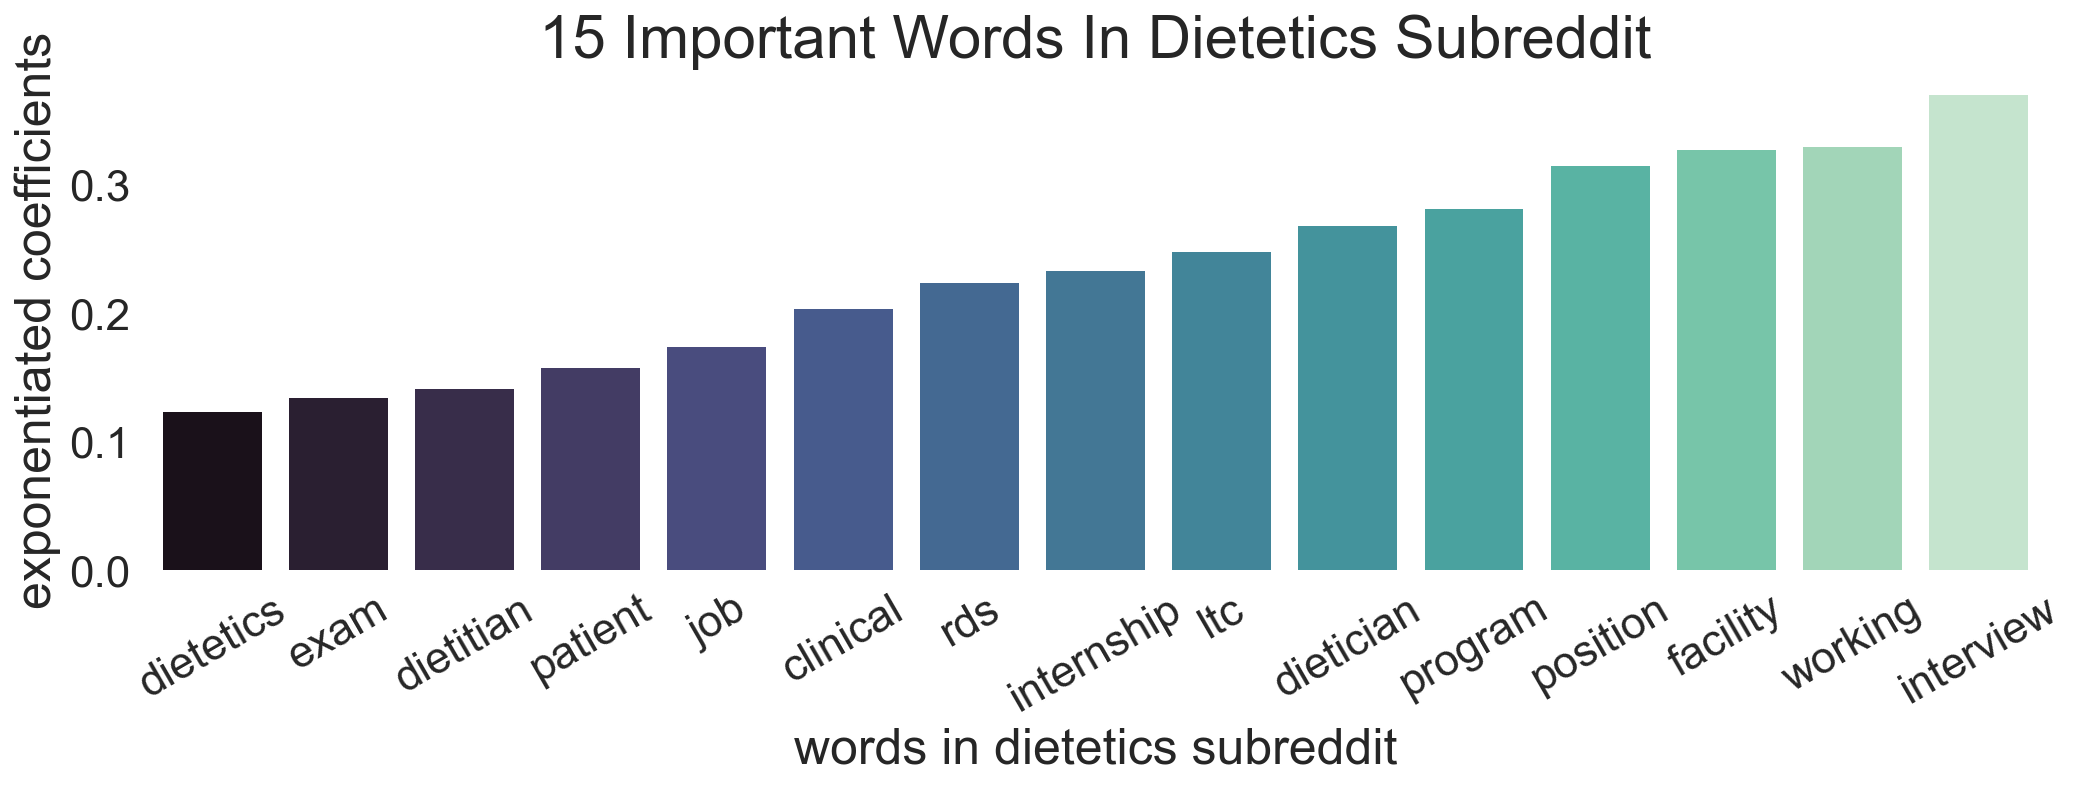

In [31]:
plt.figure(figsize=(15,6))

sns.set(font_scale=2)
sns.set_style('white')

sns.barplot(data=words_c_die,y=words_c_die['exp_coef'],x=words_c_die['features'],
           palette='mako')

plt.xlabel("words in dietetics subreddit",size=25)
plt.ylabel("exponentiated coefficients",size=25)
plt.title('15 Important Words In Dietetics Subreddit',size=30);

plt.xticks(rotation=30)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout()
plt.savefig('../images/important_words_dietetics',transparent=True);

#plot the important words out, words here are more related to job, interview, clinical
# also some technical terms like 'ltc,rds'

**dietetics is actually the most important words to predict dietetics subreddit, cause we set nutrition subreddit as 1, and dietetics subreddit as 0, so the word which has the lest coefficient are the most important words to predict dietetics subreddit**

---

## LogisticRegression with TfidfVectorizer

In [32]:
# customize the stopewords

stopwords = nltk.corpus.stopwords.words('english')
newstopwords=['rd','ve','does','nutrition','removed','deleted','would','ive','dont',"'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo']
stopwords.extend(newstopwords)

In [33]:
#https://scikit-learn.org/stable/modules/feature_extraction.html
#https://stackoverflow.com/questions/50155188/lemmatization-on-countvectorizer-doesnt-remove-stopwords
#https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer

class LemmaTokenizer:
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in stopwords]

In [34]:
pipe_t = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('tvec', TfidfVectorizer(tokenizer=LemmaTokenizer(),
                                        stop_words=stopwords))
            ]))
    ])),
    ('logreg', LogisticRegression(max_iter=10000,solver='liblinear'))
])

In [35]:
cross_val_score(pipe_t, X, y).mean()

0.8905550963517609

In [36]:
#pipe.get_params()
pipe_t.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'features', 'logreg', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__verbose', 'features__numeric_features', 'features__text_features', 'features__numeric_features__memory', 'features__numeric_features__steps', 'features__numeric_features__verbose', 'features__numeric_features__selector', 'features__numeric_features__ss', 'features__numeric_features__selector__accept_sparse', 'features__numeric_features__selector__check_inverse', 'features__numeric_features__selector__func', 'features__numeric_features__selector__inv_kw_args', 'features__numeric_features__selector__inverse_func', 'features__numeric_features__selector__kw_args', 'features__numeric_features__selector__validate', 'features__numeric_features__ss__copy', 'features__numeric_features__ss__with_mean', 'features__numeric_features__ss__with_std', 'features__text_features__memory', 'features__text_features__steps', 'features__text_features__ve

In [37]:
pipe_parames_t={'features__text_features__tvec__max_features':[3000,4000],
             'features__text_features__tvec__min_df':[2,3],
                'features__text_features__tvec__max_df':[.8,.85],
             'features__text_features__tvec__ngram_range':[(1,1),(1,2)],
             'logreg__C':np.linspace(0.0001,1,5),
             'logreg__penalty':['l1','l2']}

In [38]:
pipe_gridsearch_t=GridSearchCV(pipe_t,pipe_parames_t,cv=5)

In [39]:
pipe_gridsearch_t.fit(X_train,y_train);

In [40]:
pipe_gridsearch_t.best_score_

0.8822194645060281

In [41]:
pipe_gridsearch_t.best_params_

{'features__text_features__tvec__max_df': 0.8,
 'features__text_features__tvec__max_features': 3000,
 'features__text_features__tvec__min_df': 2,
 'features__text_features__tvec__ngram_range': (1, 2),
 'logreg__C': 1.0,
 'logreg__penalty': 'l2'}

In [42]:
train_score_t=pipe_gridsearch_t.score(X_train,y_train)
train_score_t

0.9414893617021277

In [43]:
test_score_t=pipe_gridsearch_t.score(X_test,y_test)
test_score_t

0.8951426368542791

In [44]:
train_score_t-test_score_t # also overfit, but better than previous model

0.04634672484784863

In [45]:
y_pred_t=pipe_gridsearch_t.predict(X_test)
y_pred_t

array([1, 0, 1, ..., 0, 1, 1])

In [46]:
print(classification_report(y_test,y_pred_t))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       652
           1       0.86      0.94      0.90       645

    accuracy                           0.90      1297
   macro avg       0.90      0.90      0.89      1297
weighted avg       0.90      0.90      0.89      1297



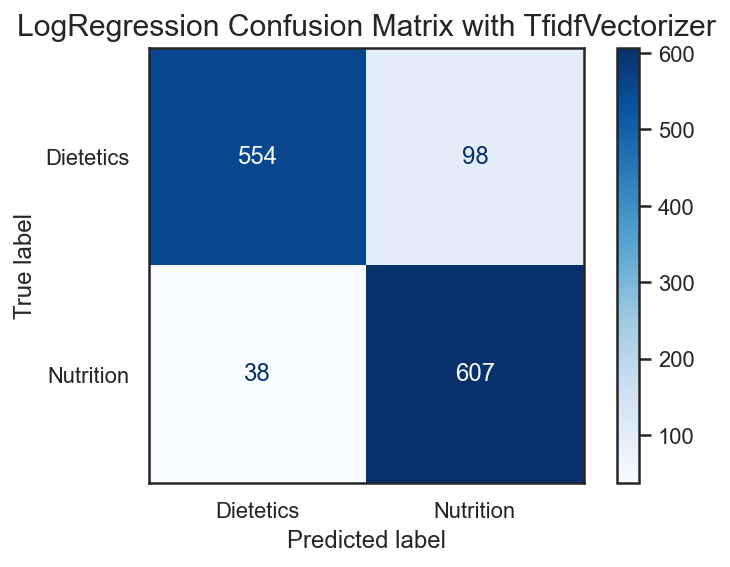

<Figure size 1440x720 with 0 Axes>

In [47]:
# Confusion Matrix for Log Regression

sns.set(font_scale=1)
sns.set_style('white')

plot_confusion_matrix(pipe_gridsearch_t, X_test, y_test, cmap='Blues', 
                      display_labels=['Dietetics', 'Nutrition'])

plt.title('LogRegression Confusion Matrix with TfidfVectorizer',size=15)

plt.figure(figsize=(20,10));

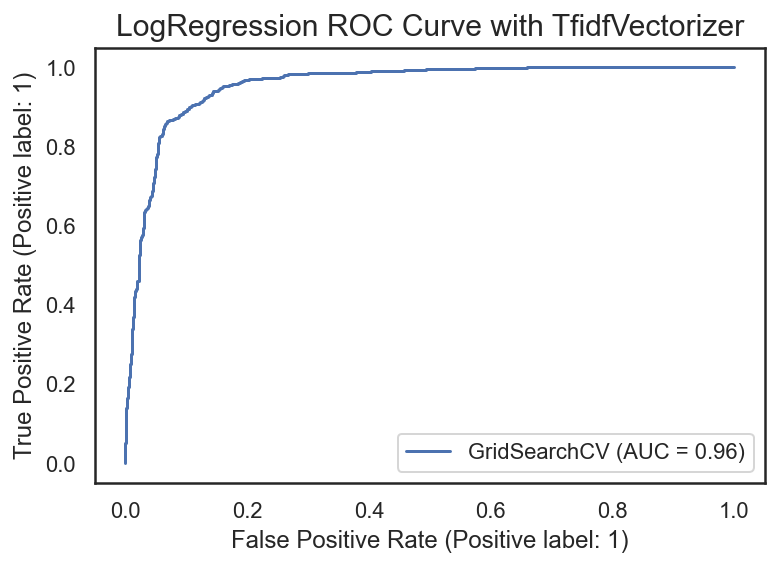

<Figure size 1440x720 with 0 Axes>

In [48]:
# ROC Curve for LogRegression

sns.set(font_scale=1)
sns.set_style('white')

plot_roc_curve(pipe_gridsearch_t,X_test,y_test)

plt.title('LogRegression ROC Curve with TfidfVectorizer',size=15)
plt.figure(figsize=(20,10));

### Features and Coefficients

In [49]:
# create a dataframe to combine the features and coefs

features = pipe_gridsearch_t.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['tvec'].get_feature_names()
coefficients = pipe_gridsearch_t.best_estimator_.named_steps['logreg'].coef_[0]

fe_co_t_df=pd.DataFrame({'features': ['nd_title_text','nd_length', 'nd_word_count','nd_sentiment']+ features, 
              'coef' : coefficients,
              'exp_coef': [np.exp(coef) for coef in coefficients]})

ValueError: arrays must all be same length

In [ ]:
fe_co_t_df.head()

> important words predicting nutrition subreddit

In [ ]:
words_t_nut=fe_co_t_df.sort_values(by=['exp_coef'],ascending=False)[:15][::-1]
words_t_nut

In [ ]:
plt.figure(figsize=(15,6))

sns.set(font_scale=2)#change the font size for charts in entire notebook
sns.set_style('white')

sns.barplot(data=words_t_nut,y=words_t_nut['exp_coef'],x=words_t_nut['features'],
           palette='magma');

plt.xlabel("words in nutrition subreddit",size=25)
plt.ylabel("exponentiated coefficients",size=25)
plt.title('15 Important Words In Nutrition Subreddit',size=30);

plt.xticks(rotation=30);

# the important words we get from TfidfVectorizer are really similiar to the important
# words we get from CountVectorizer, 

> important words predicting dietetics subreddit

In [ ]:
words_t_die=fe_co_t_df.sort_values(by=['exp_coef'])[:15]
words_t_die

In [ ]:
plt.figure(figsize=(15,6))

sns.set(font_scale=2)
sns.set_style('white')

sns.barplot(data=words_t_die,y=words_t_die['exp_coef'],x=words_t_die['features'],
           palette='mako')

plt.xlabel("words in dietetics subreddit",size=25)
plt.ylabel("exponentiated coefficients",size=25)
plt.title('15 Important Words In Dietetics Subreddit',size=30);

plt.xticks(rotation=30);

#same here, really similliar to the words from CountVectorizer

In [ ]:
'../images/'